In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import random
import pickle 
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import vist

import os.path as osp
import math
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.misc import imread, imresize

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

# Caltech Story Classification

In [2]:
with open("data/caltech_stories_patterns", 'rb') as file:
        caltech_stories_dataset = pickle.load(file)
        
train = {"features" : {"filenames" : caltech_stories_dataset["data"]["train"]}, "labels" : caltech_stories_dataset["labels"]["train"], "pattern_labels" : caltech_stories_dataset["pattern_labels"]["train"]}
valid = {"features" : {"filenames" : caltech_stories_dataset["data"]["validation"]}, "labels" : caltech_stories_dataset["labels"]["validation"], "pattern_labels" : caltech_stories_dataset["pattern_labels"]["validation"]}
test = {"features" : {"filenames" : caltech_stories_dataset["data"]["test"]}, "labels" : caltech_stories_dataset["labels"]["test"], "pattern_labels" : caltech_stories_dataset["pattern_labels"]["test"]}

caltech_data = {"training": train, "validation": valid, "test" : test}
print("Labeled and segmented the dataset into training/validation/test sets")

Labeled and segmented the dataset into training/validation/test sets


In [3]:
caltech_stories_dataset.keys()

dict_keys(['patterns', 'data', 'pattern_labels', 'labels'])

In [4]:
with open("data/caltech_features", 'rb') as file:
        caltech_features = pickle.load(file)
        
        
for _set in caltech_data:
    features = caltech_data[_set]["features"]
    filenames = features["filenames"]
    features["fc7_features"] = []
    features["fc8_features"] = []
    
    for story in filenames:
        
        fc7_features_story = []
        fc8_features_story = []
        
        for img_filename in story:
            tokens = img_filename.split("/")
            class_name = tokens[-2]
            img_name = tokens[-1] 
            
            fc7 = caltech_features[class_name][img_name]["fc7"]
            fc8 = caltech_features[class_name][img_name]["fc8"]
            
            fc7_features_story.append(fc7) 
            fc8_features_story.append(fc8)
        
        features["fc7_features"].append(fc7_features_story) 
        features["fc8_features"].append(fc8_features_story)

print("Loaded fc7 and fc8 features")

Loaded fc7 and fc8 features


In [5]:
caltech_data.keys()

dict_keys(['validation', 'training', 'test'])

In [6]:
caltech_data['training'].keys()

dict_keys(['pattern_labels', 'labels', 'features'])

In [7]:
caltech_data['training']['features'].keys()

dict_keys(['fc7_features', 'filenames', 'fc8_features'])

In [8]:
len(caltech_data['test']['features']['fc8_features'][0])

5

In [9]:
caltech_data['test']['features']['filenames'][0]

['llama/image_0009.jpg',
 'panda/image_0026.jpg',
 'butterfly/image_0008.jpg',
 'cougar_body/image_0017.jpg',
 'cup/image_0017.jpg']

In [10]:
caltech_data['test']['pattern_labels'][2]

7

# LSTM

In [11]:
def get_batch(iterable, n=1):
    """
    Yields an iteratable
    """
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        

def create_batches(data, batch_size = 100):
    """
    Generates the batches
    """
    batches = list()
    for batch in get_batch(data, batch_size):
        batches.append(batch)
    
    return batches


def transform_data(batch_size, batches_x_i):
    """
    Transforms the data
    """
        
    # transform x
    batch_x = np.zeros((batch_size, 5000))
    r = 0
    for story_imgs in batches_x_i:
        # initialize empty vector
        row = np.empty(0)
        for img_features in story_imgs:
            row = np.append(row, img_features)

        batch_x[r, :] = row
        r = r + 1
    # reshape
    batch_x = batch_x.reshape((batch_size, 5, 1000))
    
    return batch_x


def one_hot(batch_size, batches_y_i):
    """
    One hot representation for the labels
    """
        
    # labels to one hot representation
    batch_y = np.zeros((batch_size, 2))
    r = 0
    for label in batches_y_i:
        if label == 0:
            batch_y[r, :] = np.array([1,0])
        else:
            batch_y[r, :] = np.array([0,1])

        r = r + 1
        
    return batch_y

In [12]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 100
# display_step = 10

# Network Parameters
n_input = 1000 # MNIST data input (img shape: vector 1000)
n_steps = 5 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 2  # true false
number_of_layers = 3

cell_type = 1 # 0-> rnn, 1-> lstm, 2-> gru

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [13]:
def rnn_cell(n_hidden):
    return rnn.BasicRNNCell(n_hidden)

def lstm_cell(n_hidden, forget_bias = 1.0):
    return rnn.BasicLSTMCell(n_hidden, forget_bias = 1.0)

def gru_cell(n_hidden):
    cell = rnn.GRUCell(n_hidden)
#     cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = 0.5)
    return cell
    

def RNN(x, weights, biases, number_of_layers, cell_type):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    # Number of hidden layers 'number_of_layers'
    
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    
    # Define multiple cells with tensorflow
    if (cell_type == 0) :
        stacked_cells = rnn.MultiRNNCell(
            [rnn_cell(n_hidden) for _ in range(number_of_layers)])
    elif (cell_type == 1) :
        stacked_cells = rnn.MultiRNNCell(
            [lstm_cell(n_hidden, forget_bias = 1.0) for _ in range(number_of_layers)])
    elif(cell_type == 2) :
        stacked_cells = gru_cell(n_hidden)

    # Define single lstm cell with tensorflow
    #lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    
    # Get lstm cell output
    outputs, states = rnn.static_rnn(stacked_cells, x, dtype = tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out'], outputs

pred, outputs = RNN(x, weights, biases, number_of_layers, cell_type)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

ss


In [14]:
# Launch the graph
with tf.Session() as sess:
    
    # create batches for data and labels 
    train_data = caltech_data['training']['features']['fc8_features']
    train_labels = caltech_data['training']['labels']
    batches_x = create_batches(train_data, batch_size)
    batches_y = create_batches(train_labels, batch_size)

    num_of_batches = np.shape(batches_x)[0]
    
    sess.run(init)
    step = 1
    epochs = 20

    # Keep training until reach max iterations
    while step  < epochs:
        
        for i in range(num_of_batches):
            
            batch_x = transform_data(batch_size, batches_x[i])            
            batch_y = one_hot(batch_size, batches_y[i])

            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
#             print ("Batch " + str(i) + ", Minibatch Loss= " + \
#                   "{:.6f}".format(loss) + ", Training Accuracy= " + \
#                   "{:.5f}".format(acc))
        
        print ("Epoch: ", step)
        step += 1
    
    print ("Optimization Finished!")

    
    
    print("_____________Test_______________")
    
    # load test data 
    test_data = caltech_data['test']['features']['fc8_features']
    test_label = caltech_data['test']['labels']

    data_len = len(test_data)
    
    # transform data and labels
    test_data = transform_data(data_len, test_data)            
    test_label = one_hot(data_len, test_label)
    print ("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={x: test_data, y: test_label}))
    
    
    
    print("__________Hidden States__________________")
    
    train_data_len = len(train_data)

    # transform data and labels
    train_data = transform_data(train_data_len, train_data)            
    train_labels = one_hot(train_data_len, train_labels)
    
    outputs_ = sess.run(outputs, feed_dict={x: train_data, y: train_labels})
    
    print ("Took hidden states")

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Optimization Finished!
_____________Test_______________
Testing Accuracy: 0.99
__________Hidden States__________________
Took hidden states


# Keep Hidden State

In [15]:
# # Launch the graph
# with tf.Session() as sess:
    
#     # create batches for data and labels 
#     train_data = caltech_data['training']['features']['fc8_features']
#     train_labels = caltech_data['training']['labels']
    
#     train_data_len = len(train_data)
    
#     # transform data and labels
#     train_data = transform_data(train_data_len, train_data)            
#     train_labels = one_hot(train_data_len, train_labels)
    
#     sess.run(init)
#     step = 1
#     epochs = 2

#     print ("Start")
#     outputs_ = sess.run(outputs, feed_dict={x: train_data, y: train_labels})
#     print ("Finished!")



# KNN

In [16]:
def read_img(img_file):
    img_content = imread(img_file)
        
    if len(img_content.shape) == 2:
        img_content = np.tile(img_content[:,:,np.newaxis], (1,1,3))
        img_content = imresize(img_content, (224, 224))

    return img_content
    
def visualize_caltech_stories(imgs):
    plt.figure()
    cols = 5
    rows = math.ceil(len(imgs)/float(cols))
    
    for i,img in enumerate(imgs):
        img_file = osp.join('data','101_ObjectCategories', img)
        img_content = read_img(img_file)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img_content)
        ax.axis('off')
        ax.set_title(str(img))
    
    plt.show()

In [17]:
# Average Precision
def average_precision(rankings, true_type):
    # Make relevance binary
    rankings = [1 if x == true_type else 0 for x in rankings]
    
    # list to np array
    rankings = np.array(rankings)
    
    # relevant
    relevant = rankings.sum()
    relevant = 1 if relevant == 0 else relevant
    
    # Initialize
    avg_precision = 0
    
    max_k = len(rankings) + 1
    
    for k in range (1, max_k):
        precision_k = 0
        
        # Precision at rank k
        if rankings[k-1] == 1:
            precision_k = rankings[:k].sum() / k
        else:
            precision_k = 0
        
        avg_precision += precision_k
            
    avg_precision = avg_precision / relevant
        
    return avg_precision

In [18]:
print("Output shape: ", np.shape(outputs_))
last_hidden = outputs_[4]
print("Last hidden state shape: ", np.shape(last_hidden))

Output shape:  (5, 10000, 128)
Last hidden state shape:  (10000, 128)


In [19]:
nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(last_hidden)
distances, indices = nbrs.kneighbors(last_hidden)

In [20]:
indices[0]

array([   0, 5954, 6475, 8884, 5413,  587, 3039, 7430, 5869, 4231, 8197,
       9750, 1131, 4753, 4760, 9291, 5058, 5698, 8874, 4776, 2645, 3010,
       6519, 7260, 2576, 6764, 7887, 3666, 2644, 5417, 4014, 6671, 3179,
       9751, 4600, 5477, 8134, 7678, 4029,  867, 4509, 3228, 8681, 9540,
       2740, 4520, 9590, 6245, 2560, 3872, 2957,  795, 8739, 4209, 3379,
       6401, 7769, 9553, 9754, 1944, 9561, 6307, 7511, 8061, 8259, 1682,
       9734, 6870, 7945, 9215, 3190, 6246, 4143, 2949, 6450, 2286, 3276,
       5868, 8210,  375, 9647, 8780, 3211, 5377, 6090, 3903, 5687, 6595,
       3241, 8521, 2331, 3876, 4518, 7052, 4405,  450, 4929, 3238,  602,
       4349], dtype=int64)

Pattern type 2


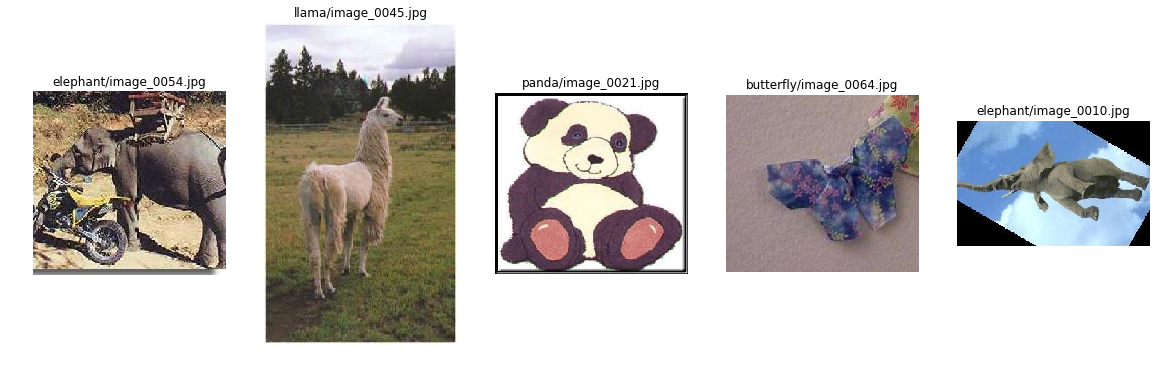

Pattern type 2


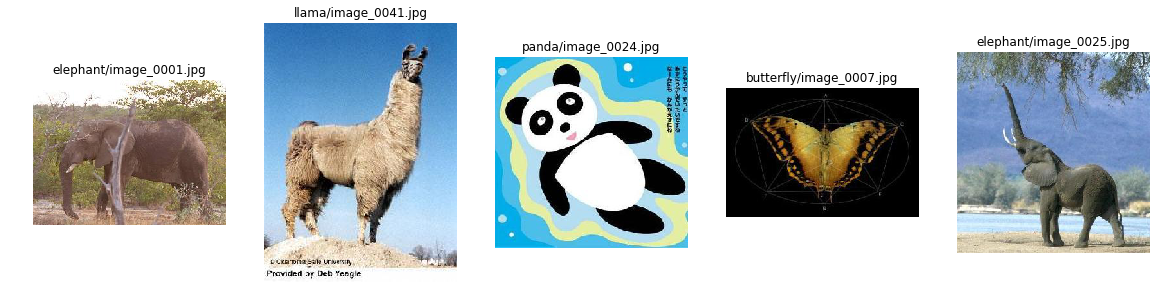

In [21]:
print("Pattern type", caltech_data['training']['pattern_labels'][0])
visualize_caltech_stories(caltech_data['training']['features']['filenames'][0])
print("Pattern type", caltech_data['training']['pattern_labels'][5954])
visualize_caltech_stories(caltech_data['training']['features']['filenames'][5954])

In [22]:
num_of_stories = len(caltech_data['training']['pattern_labels'])

mean_avg_precision = 0

for story_id in range(num_of_stories):
    rankings = [caltech_data['training']['pattern_labels'][i] for i in indices[story_id][1:]]
    true_type = caltech_data['training']['pattern_labels'][story_id]    
    mean_avg_precision = mean_avg_precision + average_precision(rankings, true_type)

mean_avg_precision = mean_avg_precision/num_of_stories

In [23]:
print(mean_avg_precision)

0.927858893411


### MNIST example

In [ ]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print ("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print ("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

In [ ]:
r = [9,9,9,9,9]

print(average_precision(r,9))